In [3]:

###################
#  IMPORTING CELL #
###################

# Install pupil_apriltags package. This a wrapper for the Apriltags3 library 
#   developed by AprilRobotics.
# Documentation at https://github.com/pupil-labs/apriltags

%pip install pupil-apriltags

# install opencv
!pip install opencv-python

!pip install av
!pip install pims
!pip install pillow
!pip install plotly





You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [4]:


# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O
import av
import pims
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go


# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

/opt/venv/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


# calibrateCamera()

In [5]:
# pickle_file is .pickle
# input_images is .zip
def calibrateCamera(pickle_file, scale): 

    # helper function
    # Returns: 
    #   imgpoints -- Nx2 numpy array of (x,y) image coords
    #   objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
    #   tag_ids -- Nx1 list of tag IDs
    def detect_aprilboard(img, board, apriltag_detector):

        imgpoints=[]
        objpoints=[]
        tagIDs=[]
        
        # detect april tags
        tags = apriltag_detector.detect(img, 
                                        estimate_tag_pose=False, 
                                        camera_params=None, 
                                        tag_size=None)
        
        if len(tags):
            # collect image coordinates of tag centers
            imgpoints = np.vstack([ sub.center for sub in tags ])

            # list of all detected tag_id's in image
            tagIDs = [ sub.tag_id for sub in tags ]

            # all board list-elements that contain one of the detected tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))    
        
            if len(objs):
                # gather the center coordinates from each of these board elements
                objpoints = np.vstack([ sub['center'] for sub in objs ])
        
        return imgpoints, objpoints, tagIDs

    # select all calibration images
    CALIBFILES = './resources_unzipped/calib0*.png'
    
    # choose pickle data for fine board
    data = pickle.load(open(pickle_file, 'rb'))
    at_coarseboard = data['at_coarseboard']
    at_fineboard = data['at_fineboard']
    BOARD = at_fineboard
   
    
    ###### BEGIN CALIBRATION SCRIPT

    # exit if no images are found or if BOARD is unrecognized
    images = glob.glob(CALIBFILES)
    assert images, "no calibration images matching: " + CALIBFILES
    assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"


    # initialize 3D object points and 2D image points
    calObjPoints = []
    calImgPoints = []

    # set up april tag detector (I use default parameters; seems to be OK)
    at_detector = Detector(families='tag36h11',
                        nthreads=1,
                        quad_decimate=1.0,
                        quad_sigma=0.0,
                        refine_edges=1,
                        decode_sharpening=0.25,
                        debug=0)


    for count,fname in enumerate(images):
        
        # read image and convert to grayscale if necessary
        orig = cv2.imread(fname)
        

        # scale image to match video
        scale_percent = scale # percent of original size
        width = int(orig.shape[1] * scale_percent / 100)
        height = int(orig.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        orig = cv2.resize(orig, dim, interpolation = cv2.INTER_AREA)        


        if len(orig.shape) == 3:
            img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
        else:
            img = orig


        # detect apriltags and report number of detections
        imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
        
        # append detections if some are found
        if len(imgpoints) and len(objpoints):
                
            # append points detected in all images, (there is only one image now)
            calObjPoints.append(objpoints.astype('float32'))
            calImgPoints.append(imgpoints.astype('float32'))


    # convert to numpy array
    calObjPoints = np.array(calObjPoints)
    calImgPoints = np.array(calImgPoints)
        
    # calibrate the camera 
    reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
        calObjPoints, 
        calImgPoints, 
        img.shape,    # image H,W for initialization of the principal point
        None,         # no initial guess for the remaining entries of calMatrix
        None,         # initial guesses for distortion coefficients are all 0
        flags = None) # default contstraints (see documentation)

    # performance check (passed): 
    # print('RMSE of reprojected points:', reprojerr)
    return calMatrix, distCoeffs
    


# computeTwoPlanes()

In [6]:
def detect_aprilboard_v2(img, board, apriltag_detector):
    # Usage:  imgpoints, objpoints, tag_ids = detect_aprilboard(img,board,AT_detector)
    #
    # Input: 
    #   image -- grayscale image
    #   board -- at_coarseboard or at_fineboard (list of dictionaries)
    #   AT_detector -- AprilTag Detector parameters
    #
    # Returns: 
    #   imgpoints -- Nx2 numpy array of (x,y) image coords
    #   objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
    #   tag_ids -- Nx1 list of tag IDs
    
    imgpoints=[]
    objpoints=[]
    tagIDs=[]
    
    # detect april tags
    imgtags = apriltag_detector.detect(img, 
                                    estimate_tag_pose=False, 
                                    camera_params=None, 
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))
        
        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))
            
            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])
    
            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))    
            
            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])
        
    return imgpoints, objpoints, tagIDs

In [75]:
def computeTwoPlanes(calMatrix, distCoeffs, two_aprilboards_img, april_pkl='./resources_unzipped/AprilBoards.pickle', verify=False):
    """
    Input:a

    calMatrix: from Arnav's calibrateCamera
    distCoeffs: from Arnav's calibrateCamera
    two_aprilboards_img : 3-color channeled numpy array img that contains two types of boards
    april_pkl: the april pickle file given in class (applied universally for all the april fine & coarse boards)

    """    
    two_aprilboards_img = cv2.cvtColor(two_aprilboards_img, cv2.COLOR_RGB2GRAY)

    #initialize at_detector
    # set up april tag detector (I use default parameters; seems to be OK)

    data = pickle.load(open(april_pkl, 'rb'))
    at_coarseboard = data['at_coarseboard']
    at_fineboard = data['at_fineboard']
    at_detector = Detector(families='tag36h11',
                        nthreads=1,
                        quad_decimate=1.0,
                        quad_sigma=0.0,
                        refine_edges=1,
                        decode_sharpening=0.25,
                        debug=0)

    # detect apriltags and report number of detections. Do this for both boards (fine and coarse).
    imgpoints_fine, objpoints_fine, tagIDs_fine = detect_aprilboard_v2(
        two_aprilboards_img,
        at_fineboard,
        at_detector)
    imgpoints_coarse, objpoints_coarse, tagIDs_coarse = detect_aprilboard_v2(
        two_aprilboards_img,
        at_coarseboard,
        at_detector)

    # compute normalized image coordinates (equivalent to K^{-1}*x)
    # 즉, imgpoints_fine 이라는 이미지 내의 좌표로 표시된 각 QR 코드의 중심부 좌표를 
    #카메라 메트릭스(카메라-to-이미지 principal위치(0,0 이 이미지 중앙, 카메라 렌즈 정중앙에 맞게), focal length)
    #와 굴절율을 고려해서 다시 재조정.
    imgpts_fine_norm = cv2.undistortPoints(imgpoints_fine, calMatrix, distCoeffs)
    imgpts_coarse_norm = cv2.undistortPoints(imgpoints_coarse, calMatrix, distCoeffs)

    # homographies from each board to normalized image pts
    H_fine,_ = cv2.findHomography(objpoints_fine[:,:2],imgpts_fine_norm)
    H_fine = 2*H_fine/(
                    np.linalg.norm(H_fine[:,0]) + np.linalg.norm(H_fine[:,1])
                    )
    # 아래의 np.atleast_2d(np.cross(H_fine[:,0],H_fine[:,1])).T 부분은 R = [r1, r2, r1 x r2] 에서 r1 x r2를 구현한 것이다.
    R_fine = np.hstack((H_fine[:,:2],np.atleast_2d(np.cross(H_fine[:,0],H_fine[:,1])).T))
    # cv2.Rodrigues: https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac
    # Converts a rotation matrix to a rotation vector or vice versa.
    rvec_fine,_ = cv2.Rodrigues(R_fine)
    R_fine,_ = cv2.Rodrigues(rvec_fine)
    tvec_fine=H_fine[:,2]

    H_coarse,_ = cv2.findHomography(objpoints_coarse[:,:2],imgpts_coarse_norm)
    # extract rotation and translation from homography: coarseboard
    H_coarse = 2*H_coarse/(np.linalg.norm(H_coarse[:,0]) + np.linalg.norm(H_coarse[:,1]))
    R_coarse = np.hstack((H_coarse[:,:2],np.atleast_2d(np.cross(H_coarse[:,0],H_coarse[:,1])).T))
    rvec_coarse,_ = cv2.Rodrigues(R_coarse)
    R_coarse,_ = cv2.Rodrigues(rvec_coarse)
    tvec_coarse=H_coarse[:,2]

    
    #LEFT TO DO 1: Get Camera coordinat system 4-vector

    # Apply G^(-T) to Pi_P
    # Pi_c = G^(-T) Pi_P ==> Let Pi_P  be the plane normal (0, 0, 1, 0)

    # We took the Presession 8 quiz and know that  Pi_c can just be calculated (r3, -r3^Tt)

    # In our case, plane_v is the fine board
    # plane_h is the coarse board

    #Output: plane_h, plane_v -- Two homogeneous 4-vectors corresponding to planes (\Pi_v, \Pi_h) in the camera-centered coordinate system.
    r3_coarse = R_coarse[:,2]
    plane_h = np.hstack([r3_coarse, -r3_coarse.T @ tvec_coarse])

    #plane_v calculation
    r3_fine = R_fine[:,2]
    plane_v = np.hstack([r3_fine, -r3_fine.T @ tvec_fine])
    # print("printing plane_h")
    # print(plane_h)

    # print("printing plane_v")
    # print(plane_v)
    #TODO 2: test code for this function

    # print(verify)
    if verify:
        plt.imshow(two_aprilboards_img, cmap="gray")
        plt.axis('off')

        #normalized_pH = plane_h / np.linalg.norm(plane_h)
        #normalized_pV = plane_v / np.linalg.norm(plane_v)
        
        pH_3vec = (plane_h / plane_h[3])[:3]
        pV_3vec = (plane_v / plane_v[3])[:3]
        print("pH_3vec:")
        print(pH_3vec)

        plane_intersection = np.cross(pH_3vec, pV_3vec)
        plane_inter_3vec = plane_intersection / plane_intersection[2]
        print("plane_inter_3vec:")
        print(plane_inter_3vec) ## This is normalized point

        # Normalized @
        axes3d = np.float32([[0,0,0], [3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)
        
        # rotate/translate axes3d object to fineplane origin and project into camera 
        imaxes_fine,_  = cv2.projectPoints(axes3d, rvec_fine, tvec_fine, calMatrix, distCoeffs)

        # eliminate the singleton dimension (quirk of openCV format, a bit annoying)
        imaxes_fine = np.squeeze(imaxes_fine) 

        plt.plot(imaxes_fine[[0,1],0], imaxes_fine[[0,1],1], color='#d62728', linewidth=6)
        plt.plot(imaxes_fine[[0,2],0], imaxes_fine[[0,2],1], color='#2ca02c', linewidth=6)
        plt.plot(imaxes_fine[[0,3],0], imaxes_fine[[0,3],1], color='#1f77b4', linewidth=6)

        # rotate/translate axes3d object to coarseplane origin and project into camera 
        imaxes_coarse,_  = cv2.projectPoints(axes3d, rvec_coarse, tvec_coarse, calMatrix, distCoeffs)

        # eliminate the singleton dimension (quirk of openCV format, a bit annoying)
        imaxes_coarse=np.squeeze(imaxes_coarse)

        plt.plot(imaxes_coarse[[0,1],0], imaxes_coarse[[0,1],1], color='#d62728', linewidth=6)
        plt.plot(imaxes_coarse[[0,2],0], imaxes_coarse[[0,2],1], color='#2ca02c', linewidth=6)
        plt.plot(imaxes_coarse[[0,3],0], imaxes_coarse[[0,3],1], color='#1f77b4', linewidth=6)
        plt.show()
        print("now vis1")
        # Visualization 1: 
        #   Back-project rays through image points (detected tags) and compute
        #   intersection of these rays with the corresponding plane. Plot the
        #   3D intersection points and see if they look right.

        # compute normalized image coordinates (equivalent to K^{-1}*x)
        # Normalized coordinates, when appended with 1 at the end, are the back-projected 
        # ray of point in the camera coordinate system. ( x, y, 1) is the 3d-space point 

        imgpts_fine_norm = cv2.undistortPoints(imgpoints_fine, calMatrix, distCoeffs)
        imgpts_fine_norm = np.squeeze(imgpts_fine_norm)  # remove extraneous size-1 dimension from openCV (annoying)

        imgpts_coarse_norm = cv2.undistortPoints(imgpoints_coarse, calMatrix, distCoeffs)
        imgpts_coarse_norm = np.squeeze(imgpts_coarse_norm)  # remove extraneous size-1 dimension from openCV (annoying)

        # back-projections are homogeneous versions of these 
        # backproj is the backprojected ray to the plane 
        backproj_fine = in2hom(imgpts_fine_norm)
        # print(backproj_fine)
        backproj_coarse = in2hom(imgpts_coarse_norm)

        # WORK HERE: 
        # Replace the following two lines to:
        #   1. Compute Nx3 array (intersect_fine) of 3D points that correspond to 
        #      intersections of backproj_fine with plane_fine
        #   2. Compute Nx3 array (intersect_coarse) of 3D points that correspond to 
        #      intersections of backproj_coarse with plane_coarse

        intersect_fine_lambda = -plane_v[3] / np.dot(backproj_fine, plane_v[:3])
        intersect_fine = np.expand_dims(intersect_fine_lambda, axis=1) * backproj_fine

        intersect_coarse_lambda = -plane_h[3] / np.dot(backproj_coarse, plane_h[:3])
        intersect_coarse = np.expand_dims(intersect_coarse_lambda, axis=1) * backproj_coarse

        # WORK HERE: 
        # Replace the following line to properly define the 3x4 camera matrix P based on 
        # the 3x3 matrix calMatrix (for input to the add_camera() function)
        P = np.hstack((calMatrix, np.zeros((3,1))))
        # K = 3x3 , P = 3x4.( Since everything is with respect to the camera coordinate system),

        # P = K[I|0]  ==> So, no rotation 

        # create figure
        print("creating figure!")
        fig = go.Figure()

        # add 3D box corners (as done above)
        fig.add_trace(go.Scatter3d(x=intersect_fine[:,0], 
                                y=intersect_fine[:,1],
                                z=intersect_fine[:,2],
                                mode='markers',
                                marker=dict(
                                    size=2,
                                    color='#1f77b4'
                                )
                                ))

        # add 3D box corners (as done above)
        fig.add_trace(go.Scatter3d(x=intersect_coarse[:,0], 
                                y=intersect_coarse[:,1],
                                z=intersect_coarse[:,2],
                                mode='markers',
                                marker=dict(
                                    size=2,
                                    color='#2ca02c'
                                )
                                ))


        # ISOSURFACE
        X, Y, Z = np.mgrid[-12:12:40j, -12:12:40j, -20:40:40j] 
        # X, Y, Z = np.mgrid[-20:20:40j, -20:20:40j, -20:40:40j] 

        implicitplane_fine = plane_v[0]*X + plane_v[1]*Y + plane_v[2]*Z + plane_v[3]
        implicitplane_coarse = plane_h[0]*X + plane_h[1]*Y + plane_h[2]*Z + plane_h[3]

        P = np.hstack((calMatrix,np.zeros((3,1))))


        # display using plotly's isosurface trace
        fig.add_trace(go.Isosurface(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=implicitplane_fine.flatten(),
            isomin=0,
            isomax=0,
            opacity=0.3,
            colorscale='blues',
            showscale=False, # remove colorbar
            ))

        fig.add_trace(go.Isosurface(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=implicitplane_coarse.flatten(),
            isomin=0,
            isomax=0,
            opacity=0.3,
            colorscale='greens',
            showscale=False, # remove colorbar
            ))

        #####



        # add camera
        h,w=two_aprilboards_img.shape
        add_camera(h,w,P,1,fig)

        # adjust aspect ratio and initial viewing direction
        fig.update_layout(scene_aspectmode='manual',
                        scene_aspectratio=dict(x=1, y=2, z=3),
                        showlegend=False,
                        scene_camera=dict(
                            up=dict(x=0, y=-1, z=0),
                            center=dict(x=0, y=0, z=0),
                            eye=dict(x=-1, y=-1, z=-5)
                        )
                        )

        fig.show()

        print("end of fig.show()")

        

    return plane_h, plane_v 


In [76]:
def visualizePlane(plane_normal, imgpoints, calMatrix, distCoeffs):
    """
    imgpoints: points in pixel coordinates, 2-vector array (? , 2)
    
    """
    fig = go.Figure()
    

    imgpts_normalized = cv2.undistortPoints(imgpoints, calMatrix, distCoeffs)
    backproj = in2hom(imgpts_normalized)
    intersect_lambda = -plane_normal[3] / np.dot(backproj, plane_normal[:3])
    intersect = np.expand_dims(intersect_fine_lambda, axis=1) * backproj


    # add 3D box corners (as done above)
    fig.add_trace(go.Scatter3d(x=intersect[:,0], 
                            y=intersect[:,1],
                            z=intersect[:,2],
                            mode='markers',
                            marker=dict(
                                size=2,
                                color='#1f77b4'
                            )
                            ))



    # ISOSURFACE
    X, Y, Z = np.mgrid[-12:12:40j, -12:12:40j, -20:40:40j]  

    implicitplane = plane_normal[0]*X + plane_normal[1]*Y + plane_normal[2]*Z + plane_normal[3]

    P = np.hstack((calMatrix,np.zeros((3,1))))


    # display using plotly's isosurface trace
    fig.add_trace(go.Isosurface(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=implicitplane.flatten(),
        isomin=0,
        isomax=0,
        opacity=0.3,
        colorscale='blues',
        showscale=False, # remove colorbar
        ))

    #####

    # adjust aspect ratio and initial viewing direction
    fig.update_layout(scene_aspectmode='manual',
                    scene_aspectratio=dict(x=1, y=2, z=3),
                    showlegend=False,
                    scene_camera=dict(
                        up=dict(x=0, y=-1, z=0),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=-1, y=-1, z=-5)
                    )
                    )

    fig.show()


In [59]:
def add_camera(h,w,camera,raysize,figobj):
# Add tetrahedral camera to pyplot figure
# h,w:      height and width of image in pixels
# camera:   3x4 camera matrix
# raysize:  length of tetrahedral edges (in world units)
# fig:      pyplot figure object
#
# Returns: 1
#
# Uses anatomy of camera matrices from Hartley and Zisserman Chapter 6

    # normalize camera such that bottom-left three-vector 
    #   corresponds to unit-length principal ray in front of camera (HZ Section 6.2.3)
    camera=camera*np.sign(np.linalg.det(camera[:,0:3]))/np.linalg.norm(camera[2,0:3])
    
    # Compute camera center (null vector of P), because Camera center is where every ray meets 
    _, _, v = np.linalg.svd(camera)
    C = np.transpose(v[-1,0:3]) / v[-1,3]

    # Back-project image corners to unit-length 3D ray segments:
    S = np.array([[0, 0, 1],       # homog image coords if top left pixel
                  [0, h-1, 1],     # bottom left 
                  [w-1, h-1, 1],   # bottom right
                  [w, 0, 1]])      # top right
    
    #   HZ equation (6.14): compute one 3D point along each ray
    X = np.transpose(np.linalg.lstsq(
        camera[:,0:3], 
        np.transpose(S)-np.expand_dims(camera[:,3],axis=1), 
        rcond=None)[0])
    
    #   unit-vectors from camera center to each 3D point
    V = X - np.tile(C, (4, 1))
    V = V / np.linalg.norm(V, ord=2, axis=1, keepdims=True)
    
    # make sure these vectors point forwards from the camera instead of backwards
    V = V*np.expand_dims(np.sign(np.sum(V * np.tile(camera[2,0:3],(4, 1)), axis=1)),axis=1)
    
    #   desired ray segments that are length raysize in these directions 
    V = np.tile(C, (4, 1)) + raysize * V
    
    # append the camera center itself to complete the four tetrahedral vertices
    V=np.vstack([C,V])

    # add camera center to figure
    figobj.add_trace(go.Scatter3d(
        x=[C[0]], 
        y=[C[1]],
        z=[C[2]],
        mode='markers',
        marker=dict(
            size=3,
            color='#ff7f0e'
        )
    )
                    )


    # add tetrahedron to figure
    figobj.add_trace(go.Mesh3d(
        # vertices of tetrahedron
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],

        # i, j and k give the vertices of triangles
        i=[0, 0, 0, 0],
        j=[1, 2, 3, 4],
        k=[2, 3, 4, 1],
        opacity=0.5,
        color='#ff7f0e'
    ))
   
    return 1



In [60]:
# Convert from Nxm inhomogeneous to Nx(m+1) homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

In [61]:
# def plot_isosurfaces(plane_h, plane_v):


# processVideo()

In [89]:
def video2array(pathname, scale):
    cap = cv2.VideoCapture(pathname)
    success,image = cap.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    video = cv2.rotate(gray, cv2.ROTATE_180) # this video is upside down for some reason

    scale_percent = scale # percent of original size
    width = int(video.shape[1] * scale_percent / 100)
    height = int(video.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    video = cv2.resize(video, dim, interpolation = cv2.INTER_AREA)

    while success:
        success, image = cap.read()
        if success:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.rotate(gray, cv2.ROTATE_180) 
            video = np.dstack((video, cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)))

    video = np.float32(video)/255
    return video

In [90]:
# front_edge_times -- HxW array with each element storing the time (in units of frame number) 
# at which the leading shadow edge crosses that pixel.
# Optionally, a second HxW array with each element storing the time (in units of frame number) 
# at which the trailing shadow edge crosses that pixel.
# Entries in these arrays that are NaN or (-1) indicate that no shadow edge was detected at the pixel.
#
# Input: H x W x T video array

def get_front_edge_times(video):
    biggest = np.max(video, axis=2)
    smallest = np.min(video, axis=2)
    norm = biggest/2 + smallest/2

    video_norm = video - norm[:,:,np.newaxis]

    signs = np.sign(video_norm)
    shadows = np.argmin(signs, axis=2)
    
    front_edge_times = np.where(shadows < 10, -1, shadows)
    
    return front_edge_times

In [91]:
# image_lines -- length-T list of 2x3 arrays. 
# The ith 2x3 array contains the homogeneous coordinates of the two image lines (as rows) 
# on the horizontal and vertical planes in the ith video frame.
#
# Input: front_edge_times

def get_image_lines(front_edge_times, mask_top, mask_bottom, T):
    image_lines = []
    
    for t in range(T):
        # top line:
        top_board = np.zeros_like(front_edge_times)
        top_board = np.where(front_edge_times == t, 1, top_board)
        top_board = np.where(mask_top == 0, 0, top_board)
        
        y,x = np.nonzero(top_board)
        X = np.vstack((x,y)).T
        A = in2hom(X)
        U,D,VT = np.linalg.svd(A)
        l_top = VT[-1,]
        
        # bottom line:
        bottom_board = np.zeros_like(front_edge_times)
        bottom_board = np.where(front_edge_times == t, 1, bottom_board)
        bottom_board = np.where(mask_bottom == 0, 0, bottom_board)
        
        y,x = np.nonzero(bottom_board)
        X = np.vstack((x,y)).T
        A = in2hom(X)
        U,D,VT = np.linalg.svd(A)
        l_bottom = VT[-1,]
        
        image_lines.append(np.vstack((l_top, l_bottom)))
    
    return image_lines

In [92]:
def processVideo(video_pathname, scale, mask_top, mask_bottom):
    video = video2array(video_pathname, scale)
    front_edge_times = get_front_edge_times(video)
    image_lines = get_image_lines(front_edge_times, mask_top, mask_bottom, video.shape[2])
    return front_edge_times, image_lines

# computeShadowPlanes()

In [120]:
def computeShadowPlanes(K, distCoeff, image_lines, Pi_h, Pi_v):  
    shadow_planes = []
    num_frames = len(image_lines)
    for T in range(num_frames):
        # choose corect frame
        l_v = image_lines[T][0]
        l_h = image_lines[T][1]
        if (np.all(np.array([0,0,1]) == l_v) or np.all(np.array([0,0,1]) == l_h)):
            shadow_planes.append(np.array([np.nan, np.nan, np.nan, np.nan]))
            continue

        # pick 2 points on l_h and l_v, inhom
        p1_h = np.array([0, -l_h[2]/l_h[1]])   # x-int
        p2_h = np.array([-l_h[2]/l_h[1], 0])   # y-int
        p1_v = np.array([0, -l_v[2]/l_v[1]])   # x-int
        p2_v = np.array([-l_v[2]/l_v[1], 0])   # y-int
        P = np.array([p1_h, p2_h, p1_v, p2_v]) 
        print("P", P)

        # backproj these points to get backproj rays
        P_rays = cv2.undistortPoints(P, K, distCoeff)
        P_rays = np.squeeze(P_rays)  # remove extraneous size-1 dimension 
        P_rays = np.concatenate([P_rays, np.ones((P_rays.shape[0], 1), dtype=np.float32)], axis=1)   # make hom
        P_rays_h = P_rays[0:2]  # only h rays
        P_rays_v = P_rays[2:4]  # only v rays
        print("Prays_h", P_rays_h)
        print("Prays_v", P_rays_v)

        # find intersect of _h with Pi_h and _v with Pi_v
        n_h = Pi_h[:-1]  # remove last elem, plane norm vec
        s_h = Pi_h[-1]   # only last elem, dist from origin
        llambda_h = -s_h/(np.dot(P_rays_h, n_h))  # create Nx1 array which has values of how much to scale every point
        threed_h = np.expand_dims(llambda_h, axis=1)*P_rays_h  # 2 3d points on Pi_h
        print(threed_h)

        n_v = Pi_v[:-1]  # remove last elem, plane norm vec
        s_v = Pi_v[-1]   # only last elem, dist from origin
        llambda_v = -s_v/(np.dot(P_rays_v, n_v))  # create Nx1 array which has values of how much to scale every point
        threed_v = np.expand_dims(llambda_v, axis=1)*P_rays_v  # 2 3d points on Pi_v
        print(threed_v)
        
        # turn Xi to homogeneous, and compute shadow plane with 4 points using SVD
        A = np.vstack((threed_h,threed_v))
        A = np.concatenate([A, np.ones((A.shape[0], 1), dtype=np.float32)], axis=1)  # make 3d points hom
        print(A)
        _,_,VT = np.linalg.svd(A)

        # plane of best-fit is the last row of V-transpose (i.e., last column of V)
        shadow_planes.append(VT[-1,])
    
    return np.array(shadow_planes)



In [121]:
l = np.array([0,0,1])
if (np.all(np.array([0,0,1]) == l)):
    print(np.array([np.nan, np.nan, np.nan, np.nan]))

[nan nan nan nan]


# computeObjectPoints()

In [122]:
# object_mask_adrs = "resources_unzipped/mask_object.png"
def computeObjectPoints(K, distCoeff, object_mask_adrs, shadow_planes, front_edge_times): 
    # resize object_mask to same dimensions as front_edge_times
    object_mask = cv2.imread(object_mask_adrs, 0)
    scale_percent = 40
    width = int(object_mask.shape[1] * scale_percent / 100)
    height = int(object_mask.shape[0] * scale_percent / 100)
    dim = (width, height)
    object_mask = cv2.resize(object_mask, dim, interpolation = cv2.INTER_AREA)


    # create blank output file
    (H,W) = object_mask.shape
    point_cloud = np.zeros((H,W,3))

    # iterate over every pixel
    for h in range(H):
        for w in range(W):
            if object_mask[h,w] == 0:
                point_cloud[h,w] = np.array([np.NaN, np.NaN, np.NaN])
            else: 
                # backproj valid pixel (h,w) and convert to hom  
                pt = np.array([h,w]).astype(float)          
                d = cv2.undistortPoints(pt, K, distCoeff)
                d = np.squeeze(d)  # remove extraneous size-1 dimension 
                d = np.append(d, [1])   # make hom
            
                # find shadow plane for specific pixel
                Pi_s = shadow_planes[front_edge_times[h,w]]
                if (np.all(Pi_s == np.array([np.nan, np.nan, np.nan, np.nan]))):
                    continue

                # calculate 3d obj point
                n = Pi_s[:-1]  # remove last elem, plane norm vec
                s = Pi_s[-1]   # only last elem, dist from origin
                llambda = -s/(np.dot(n, d))  # distance along ray from img plane to 3d
                obj_point = np.expand_dims(llambda, axis=0)*d  # we now have 3-vec for 3d point on Pi_s
                
                # print(obj_point)
                # add value to point_cloud
                point_cloud[h,w] = obj_point
    
    return point_cloud 

# visualizeObjectPoints()

In [95]:
def visualizeObjectPoints2(Point_cloud):
    # Usage:  visualizeObjectPoints(Point_cloud)
    #
    # Input: 
    #   Point_cloud --  HxWx3 array with (X,Y,Z) point coordinates at each object pixel.
    #                   Values of Nan or -1 indicate pixels that are outside of the object mask.
    #
    # Returns: 
    #   none
    
    #define the image and the 3D axises
    fig=plt.figure()
    ax2 = Axes3D(fig)
    
    Point_cloud_X=  Point_cloud[:,:,0]
    Point_cloud_Y=  Point_cloud[:,:,1]
    Point_cloud_Z=  Point_cloud[:,:,2]
    
    # X = Point_cloud_X.reshape(Point_cloud_X.shape[0]*Point_cloud_X.shape[1],1);
    # Y = Point_cloud_Y.reshape(Point_cloud_X.shape[0]*Point_cloud_X.shape[1],1);
    # Z = Point_cloud_Z.reshape(Point_cloud_X.shape[0]*Point_cloud_X.shape[1],1);
    
    ax2.scatter3D(Point_cloud_X,Point_cloud_Y,Point_cloud_Z, cmap='Blues')  #绘制散点图
    plt.title('Point_cloud')
    plt.show()

In [96]:
def visualizeObjectPoints(point_cloud):
    """
    point_cloud: 2d array, whose rows are [x,y,z] in the camera coordinate system.
    img_shape : (h,w)
    """
    # create figure
    fig = go.Figure()

    # add 3D box corners (as done above)
    fig.add_trace(go.Scatter3d(x=point_cloud[:,:,0], 
                            y=point_cloud[:,:,1],
                            z=point_cloud[:,:,2],
                            mode='markers',
                            marker=dict(
                                size=2,
                                color='#1f77b4'
                            )
                            ))

    
    # add camera
    # h,w=img_shape
    # add_camera(h,w,P,1,fig)

    # adjust aspect ratio and initial viewing direction
    fig.update_layout(scene_aspectmode='manual',
                    scene_aspectratio=dict(x=1, y=2, z=3),
                    showlegend=False,
                    scene_camera=dict(
                        up=dict(x=0, y=-1, z=0),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=-1, y=-1, z=-5)
                    )
                    )

    fig.show()


# Main 

In [97]:
SCALE = 40

In [98]:
def resize(image, scale):
    scale_percent = scale # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [99]:
mask_top = cv2.cvtColor(resize(cv2.imread('./resources_unzipped/mask_top.png'), SCALE), cv2.COLOR_BGR2GRAY)
mask_bottom = cv2.cvtColor(resize(cv2.imread('./resources_unzipped/mask_bottom.png'), SCALE), cv2.COLOR_BGR2GRAY)
object_mask_adrs = "resources_unzipped/mask_object.png"
mask_object = cv2.cvtColor(resize(cv2.imread(object_mask_adrs), SCALE), cv2.COLOR_BGR2GRAY)
test_img = resize(cv2.imread('./resources_unzipped/still_frame_shadow2.png'), SCALE)
video_pathname = './resources_unzipped/shadow2.MOV'

In [100]:
K, dist = calibrateCamera('./resources_unzipped/AprilBoards.pickle', SCALE)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:103: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [101]:
Pi_h, Pi_v = computeTwoPlanes(K, dist, test_img, verify=False)

In [107]:
front_edge_times, image_lines = processVideo(video_pathname, SCALE, mask_top, mask_bottom)

# works up to here

In [115]:
print(image_lines[0])

[[0. 0. 1.]
 [0. 0. 1.]]


In [112]:
shadow_planes = computeShadowPlanes(K, dist, image_lines, Pi_h, Pi_v)


lv [0. 0. 1.]
l_h [0. 0. 1.]
P [[  0. -inf]
 [-inf   0.]
 [  0. -inf]
 [-inf   0.]]
Prays_h [[nan nan  1.]
 [nan nan  1.]]
Prays_v [[nan nan  1.]
 [nan nan  1.]]
[[nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]]
[[nan nan nan  1.]
 [nan nan nan  1.]
 [nan nan nan  1.]
 [nan nan nan  1.]]
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

divide by zero encountered in double_scalars

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

divide by zero encountered in double_scalars

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

divide by zero encountered in double_scalars



LinAlgError: SVD did not converge

In [ ]:
point_cloud = computeObjectPoints(K,dist, object_mask_adrs, shadow_planes, front_edge_times)
# visualizeObjectPoints(point_cloud, front_edge_times.shape)


In [ ]:
visualizeObjectPoints(point_cloud)

In [ ]:
print(point_cloud.shape)

(432, 768, 3)


In [ ]:
# print(np.where(point_cloud>0))
print(point_cloud[181,288])

[-4.26596125  7.07082974 68.16843097]


pH_3vec:
[ 0.00180459 -0.04671793 -0.02791415]
plane_inter_3vec:
[-1.37104732 -0.65046379  1.        ]


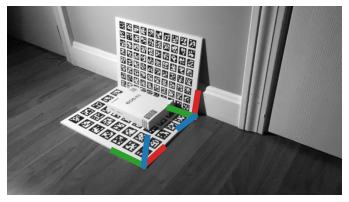

now vis1
creating figure!


In [ ]:
test_img = resize(cv2.imread('./resources_unzipped/still_frame_shadow2.png'), SCALE)
Pi_h, Pi_v = computeTwoPlanes(K, dist, test_img, verify=True)

In [ ]:
test_img = cv2.imread('./resources_unzipped/still_frame_shadow2.png')
Pi_h, Pi_v = computeTwoPlanes(K, dist, test_img, verify=True)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
#create figure
fig = go.Figure()

# add 3D box corners (as done above)
fig.add_trace(go.Scatter3d(x=point_cloud[:,:,0], 
                           y=point_cloud[:,:,1],
                           z=point_cloud[:,:,2],
                           mode='markers',
                           marker=dict(
                               size=3,
                               color='#1f77b4'
                           )
                          ))


# adjust aspect ratio and initial viewing direction
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=2, z=3),
                  showlegend=False,
                  scene_camera=dict(
                      up=dict(x=0, y=-1, z=0),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-1, y=-1, z=-5)
                  )
                  )

fig.show()
